
Top 3 escenarios por personas_pred:
   temporada  anio       segmento Tipo_viajero  personas_pred
Semana Santa  2025      económico      Familia           2383
Semana Santa  2025 precio-calidad      Familia           2115
Semana Santa  2025      económico       Pareja           1482
Total personas (Top 3): 5980


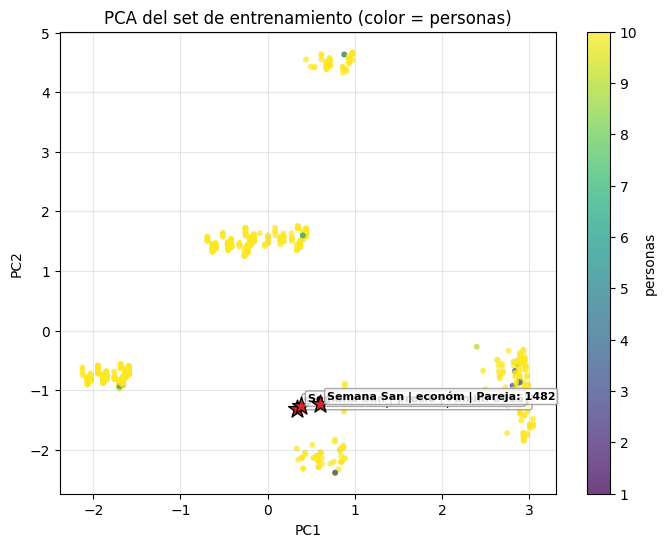

In [9]:
# =========================================
# PCA limpio (regresión) + overlay de predicciones del modelo KNN
# =========================================
# Requisitos: pandas, numpy, matplotlib, scikit-learn, joblib (y pycaret si usaste .pkl)
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import joblib

# ---------- RUTAS (ajusta a tu entorno) ----------
TRAIN_CSV     = Path(r"C:\Users\FABIO\Downloads\temporadas_SEG_TIPO_recalibrado_2020_2024_50k.csv")  # agregado 2020–2024
MODEL_PATH    = Path(r"C:\Users\FABIO\Downloads\modelo_knn_temporadas_personas.joblib")          # tu .joblib
SCENARIO_CSV  = Path(r"C:\Users\FABIO\Downloads\mis_escenarios_2025.csv")                        # opcional
FIG_OUT       = Path(r"C:\Users\FABIO\Downloads\pca_temporadas_overlay.png")

# ---------- CONFIG ----------
SUBSAMPLE_N = 800      # para que el scatter sea legible (None para usar todo)
DPI         = 180
CMAP        = "viridis"  # color por valor de personas

# ---------- LECTURA Y LIMPIEZA ----------
df = pd.read_csv(TRAIN_CSV, encoding="utf-8-sig")
# En tus datasets el target puede llamarse 'personas' o 'personas_total'
TARGET = "personas" if "personas" in df.columns else "personas_total"
if TARGET not in df.columns:
    raise ValueError("No encuentro la columna objetivo (ni 'personas' ni 'personas_total').")

# Unificar rótulos de puentes
if "temporada" in df.columns:
    df["temporada"] = df["temporada"].astype(str).str.replace(r"^Puente festivo.*", "Puente festivo", regex=True)

# ---------- FEATURES ----------
cat_cols = ["temporada","segmento","Tipo_viajero"]
num_cols = ["anio","duracion_dias","mes_inicio","es_evento_ciudad","es_semana_santa","es_navidad","es_puente"]
use_cols = cat_cols + num_cols + [TARGET]
df = df[use_cols].copy()

# One-hot para categóricas
X_cat = pd.get_dummies(df[cat_cols], drop_first=True)
X_num = df[num_cols].apply(pd.to_numeric, errors="coerce")
X_num = X_num.fillna(0.0)

X_full = pd.concat([X_num, X_cat], axis=1)
y = pd.to_numeric(df[TARGET], errors="coerce").fillna(0.0)

# Submuestreo opcional (solo para la visualización)
if SUBSAMPLE_N and SUBSAMPLE_N < len(df):
    idx = np.random.RandomState(42).choice(len(df), size=SUBSAMPLE_N, replace=False)
    X_plot = X_full.iloc[idx].reset_index(drop=True)
    y_plot = y.iloc[idx].reset_index(drop=True)
else:
    X_plot = X_full.copy()
    y_plot = y.copy()

# ---------- PCA (imputación + escalado + proyección) ----------
imp = SimpleImputer(strategy="median").fit(X_full.values)
sc  = StandardScaler().fit(imp.transform(X_full.values))
pca = PCA(n_components=2, random_state=42).fit(sc.transform(imp.transform(X_full.values)))

Z = pca.transform(sc.transform(imp.transform(X_plot.values)))

# ---------- GRAFICAR: fondo coloreado por 'personas' ----------
plt.figure(figsize=(8,6))
p = plt.scatter(Z[:,0], Z[:,1], c=y_plot.values, cmap=CMAP, s=18, alpha=0.75, edgecolors="none")
cb = plt.colorbar(p); cb.set_label(TARGET)

plt.title("PCA del set de entrenamiento (color = personas)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.grid(True, alpha=0.3)

# ---------- OVERLAY (opcional): escenarios + predicción del modelo ----------
stars = []
if SCENARIO_CSV.exists():
    try:
        model = joblib.load(MODEL_PATH); use_pycaret = False
    except Exception:
        from pycaret.regression import load_model, predict_model
        model = load_model(str(MODEL_PATH).replace(".joblib","")); use_pycaret = True

    scn = pd.read_csv(SCENARIO_CSV, encoding="utf-8-sig")
    scn["temporada"] = scn["temporada"].astype(str).str.replace(r"^Puente festivo.*", "Puente festivo", regex=True)

    # Alinear columnas del PCA
    Xs_cat = pd.get_dummies(scn[cat_cols], drop_first=True).reindex(columns=X_cat.columns, fill_value=0)
    Xs_num = scn[num_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0)
    Xs = pd.concat([Xs_num, Xs_cat], axis=1)
    Zs = pca.transform(sc.transform(imp.transform(Xs.values)))

    # Predicciones
    if not use_pycaret:
        yhat = model.predict(scn)
    else:
        from pycaret.regression import predict_model
        yhat = predict_model(model, data=scn)["prediction_label"].values

    # === Mostrar SOLO las 3 mayores predicciones ===
    K = 3
    idx_top = np.argsort(-yhat)[:K]

    for i in idx_top:
        plt.scatter(Zs[i,0], Zs[i,1], s=180, marker="*", c="tab:red",
                    edgecolor="k", linewidths=1.0, zorder=3)
        lbl = f"{scn.loc[i,'temporada'][:10]} | {scn.loc[i,'segmento'][:6]} | {scn.loc[i,'Tipo_viajero'][:6]}: {int(round(yhat[i]))}"
        plt.text(Zs[i,0]+0.08, Zs[i,1]+0.08, lbl, fontsize=8, weight="bold",
                 bbox=dict(boxstyle="round,pad=0.2", fc="w", ec="0.6", alpha=0.85))

    # (Opcional) imprimir cuántas personas muestran esas 3 estrellas
    resumen = scn.loc[idx_top, ["temporada","anio","segmento","Tipo_viajero"]].copy()
    resumen["personas_pred"] = np.round(yhat[idx_top]).astype(int)
    print("\nTop 3 escenarios por personas_pred:")
    print(resumen.to_string(index=False))
    print("Total personas (Top 3):", int(np.round(yhat[idx_top].sum())))

    


In [10]:
import numpy as np
scn2 = scn.copy()
scn2["personas_pred"] = np.round(yhat).astype(int)

def top3_por_temp(df):
    out = []
    for temp, g in df.groupby("temporada"):
        idx = np.argsort(-g["personas_pred"].values)[:3]
        out.append(g.iloc[idx])
    return pd.concat(out, ignore_index=True)

top3_temp = top3_por_temp(scn2)
top3_temp.to_csv(r"C:\Users\FABIO\Downloads\top3_por_temporada.csv", index=False, encoding="utf-8-sig")
print("Top-3 por temporada guardado en:", r"C:\Users\FABIO\Downloads\top3_por_temporada.csv")


Top-3 por temporada guardado en: C:\Users\FABIO\Downloads\top3_por_temporada.csv
